In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

from hw3.direct_kernel_regression import direct_kernel_regression_estimate
from hw3.common import COL, estimate_loss


In [193]:
df = pd.read_csv('UJIndoorLoc/trainingData.csv')
test_df = pd.read_csv('UJIndoorLoc/validationData.csv')


In [4]:
test_df


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,100,100,100,100,100,100,100,100,100,100,...,100,-7317.344231,4.864796e+06,3,2,0,0,0,13,1381156711
1107,100,100,100,100,100,100,100,100,100,100,...,100,-7313.731120,4.864792e+06,3,2,0,0,0,13,1381156730
1108,100,100,100,100,100,100,100,100,100,100,...,100,-7637.535798,4.864903e+06,0,0,0,0,0,13,1381247781
1109,100,100,100,100,100,100,100,100,100,100,...,100,-7636.654005,4.864905e+06,0,0,0,0,0,13,1381247807


In [197]:
## missing wap!
np.where(df.min() == 100)

(array([  2,   3,  91,  92,  93,  94, 151, 157, 158, 159, 214, 216, 225,
        226, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 253, 292,
        295, 300, 302, 303, 306, 332, 348, 352, 359, 364, 415, 418, 422,
        428, 432, 437, 440, 441, 443, 444, 450, 457, 481, 484, 486, 487,
        490, 496, 519]),)

In [194]:
df.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,...,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,...,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


In [200]:
np.mean(np.sum(df[COL.WAPs] != 100, axis=1))

17.994833726237648

# Strategy 1: direct estimation


## Use library function

In [208]:
from hw3.direct_kernel_regression import DirectKernelRegression

dkr = DirectKernelRegression(df, subsample=0.03)

Building classifier score: 1.0


In [209]:
dkr.get_wap_locations()

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID
0,-7461.616707,4.864870e+06,1.653846,1
1,-7639.180100,4.864913e+06,2.000000,0
2,-7461.616707,4.864870e+06,1.653846,1
3,-7461.616707,4.864870e+06,1.653846,1
4,-7313.933481,4.864802e+06,2.514828,2
...,...,...,...,...
515,-7334.611039,4.864816e+06,0.888791,2
516,-7350.488392,4.864819e+06,1.927788,2
517,-7327.492165,4.864767e+06,3.000000,2
518,-7461.616707,4.864870e+06,1.653846,1


In [ ]:
test_coor, debug_info = dkr.estimate(test_df[COL.WAPs])

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(debug_info['cv_loss'])
plt.xlabel('h')
plt.ylabel('loss')

In [ ]:
dkr.analyze_and_dump(test_df[[COL.LON, COL.LAT, COL.FLR, COL.BID]], test_coor)

# Now we move to the router-based method


## Test lib function!


In [68]:
from hw3.wap_based import FloorPolynomialApproach


In [71]:
fpa = FloorPolynomialApproach(df, polynomial_degree=3)
# fpa = FloorPolynomialApproach(df, save_path='param/fpa_20230409_150208')

Building classifier score: 1.0
Building classifier score: 1.0


In [72]:
# sp, s, w = fpa.train(n_epoch=3, n_mini_inner=3)
fpa.train(n_epoch=2, n_mini_inner=20)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [73]:
fpa.polynomial.coeff

Parameter containing:
tensor([ 1.4095,  0.1129, -1.5631, -3.0272], requires_grad=True)

<Figure size 640x480 with 0 Axes>

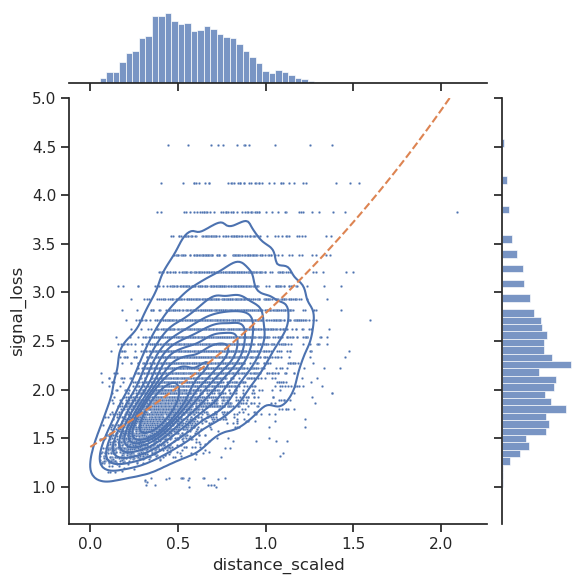

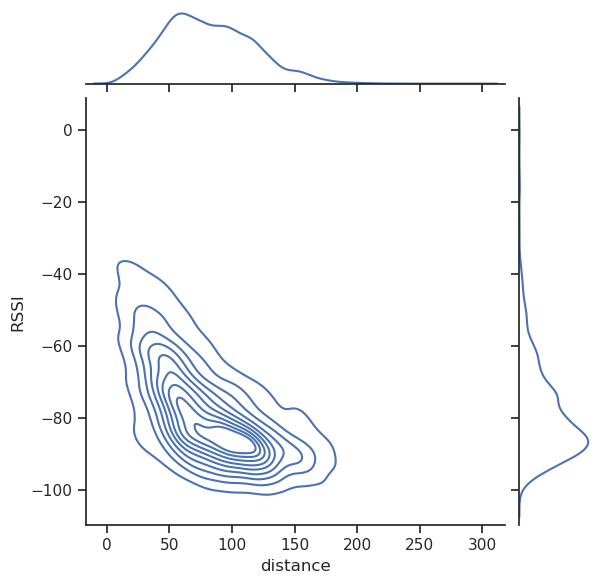

In [74]:
fpa.interpret()

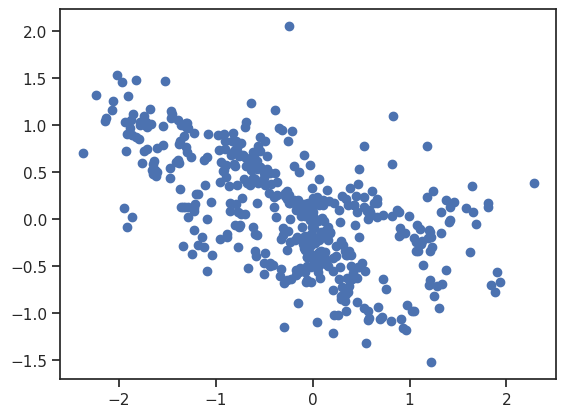

In [75]:
wap = fpa.wap_coor.detach().numpy()

plt.scatter(wap[:, 0], wap[:, 1])

In [79]:
fpa.save()

In [76]:
test_coor, debug_info = fpa.estimate(test_df[COL.WAPs], n_test_itr=2000, nan_penalty=0.00, batch_size=300)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [77]:
test_coor.FLOOR.mean(), test_coor.FLOOR.std()

(1.0666066606660667, 1.0582456615927702)

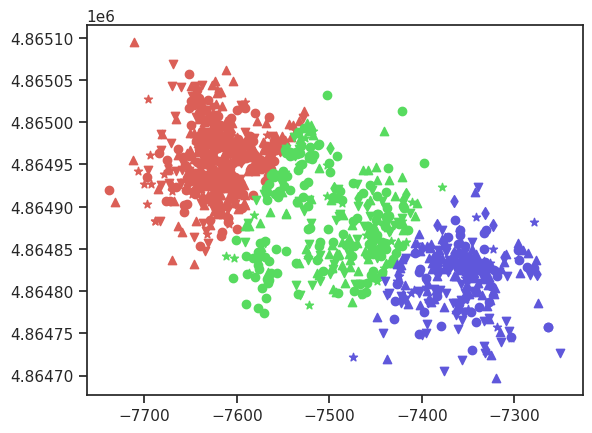

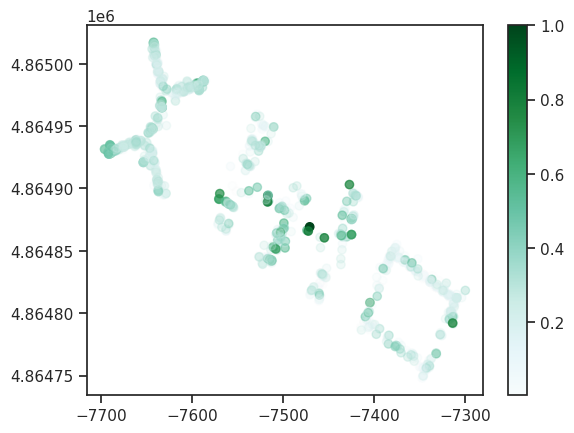

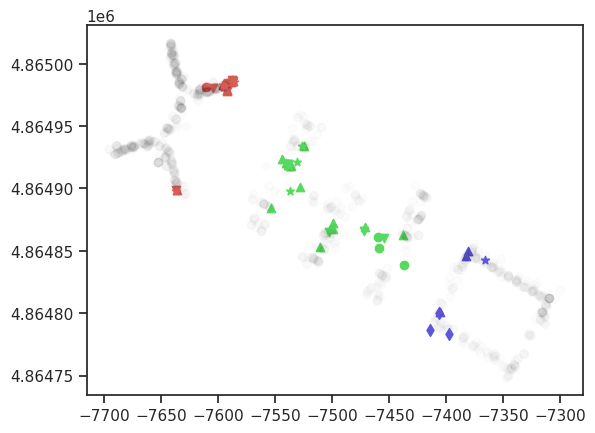

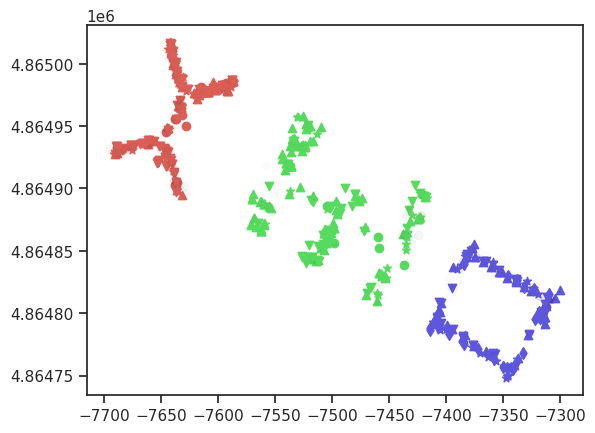

In [78]:
fpa.analyze_and_dump(test_df[[COL.LON, COL.LAT, COL.FLR, COL.BID]], test_coor)

# GMM!

In [113]:
from hw3.wap_based_gmm import GMMApproach

In [114]:
gmma = GMMApproach(df, hidden_dim=80, depth = 5, block_per_group=3, batch_size=500, activation='swish')

Building classifier score: 1.0
Building classifier score: 1.0


Preparing data...:   0%|          | 0/40 [00:00<?, ?it/s]

In [115]:
history = gmma.train(n_epoch=5, n_mini_inner=1)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[None]

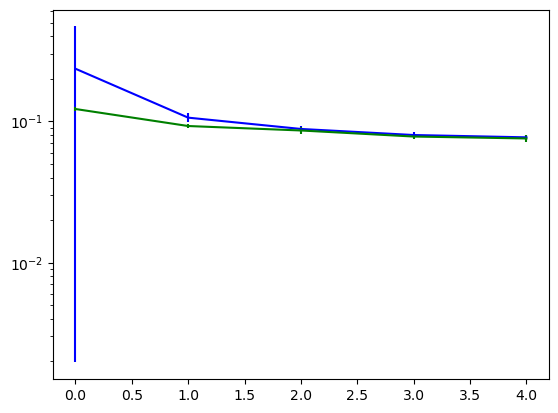

In [116]:
plt.figure()
tlmean = [np.mean(tl) for tl, vl in history]
tlstd = [np.std(tl) for tl, vl in history]
vlmean = [np.mean(vl) for tl, vl in history]
vlstd = [np.std(vl) for tl, vl in history]
plt.errorbar(np.arange(len(history)), tlmean, tlstd, color='b')
plt.errorbar(np.arange(len(history)), vlmean, vlstd, color='g')
plt.gca().set(yscale='log')

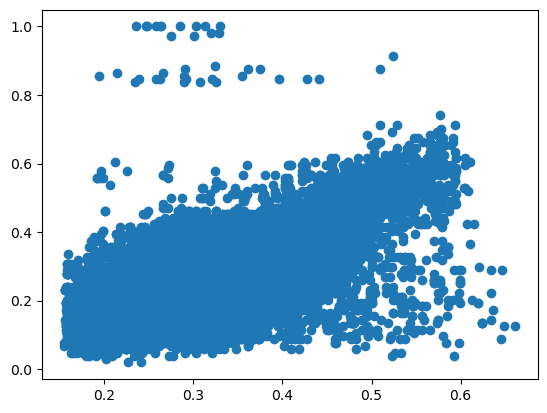

In [117]:
gmma.interpret()

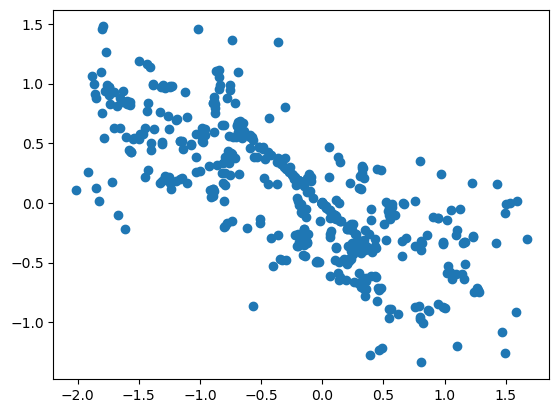

In [109]:
wap = gmma.wap_coor.detach().numpy()

plt.scatter(wap[:, 0], wap[:, 1])

In [112]:
test_coor, debug_info = gmma.estimate(test_df[COL.WAPs], n_test_itr=200, nan_penalty=0.00, batch_size=1)

  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

tensor([[0.2816, 0.1635],
        [0.2788, 0.1731],
        [0.3865, 0.3173],
        [0.3868, 0.3077],
        [0.3537, 0.4712],
        [0.3552, 0.4712],
        [0.2914, 0.1538],
        [0.3382, 0.3173],
        [0.3248, 0.3365],
        [0.3261, 0.3269],
        [0.3635, 0.4135],
        [0.1636, 0.1442],
        [0.3929, 0.2212],
        [0.3793, 0.1923],
        [0.3461, 0.1538],
        [0.2626, 0.1731],
        [0.3841, 0.1731],
        [0.3616, 0.2500]], grad_fn=<CatBackward0>)


RuntimeError: No active exception to reraise

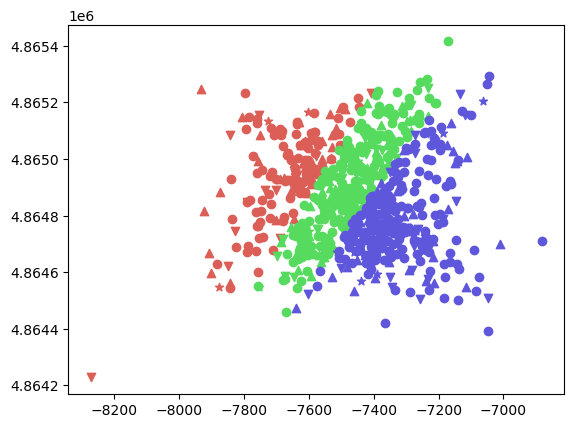

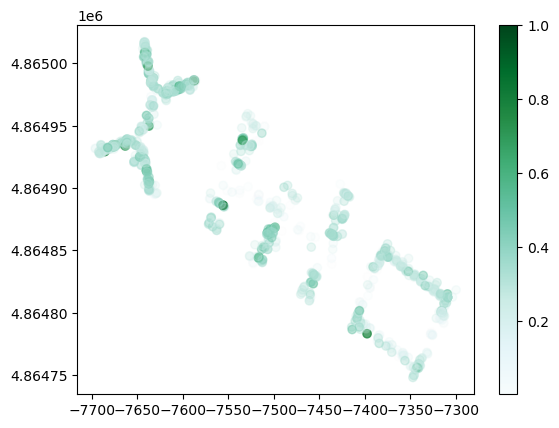

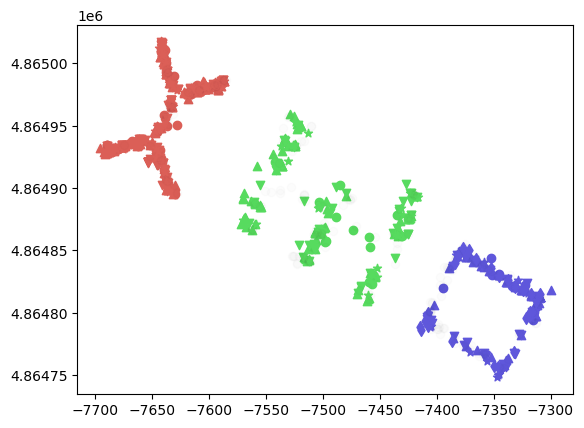

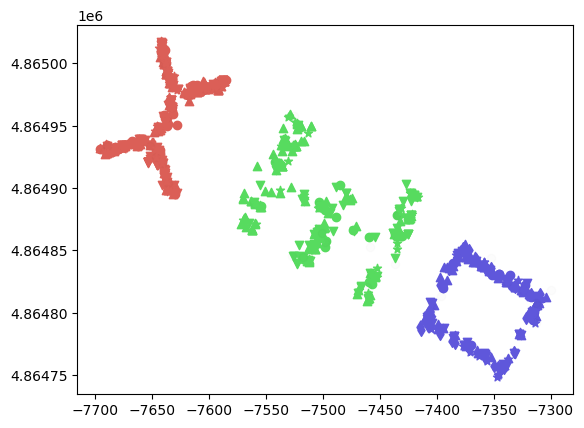

In [111]:
gmma.analyze_and_dump(test_df, test_coor)